# Calibration of Black and Scholes, Merton, Kou, Variance Gamma parameters
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.

*reference: https://github.com/cantaro86/Financial-Models-Numerical-Methods/tree/master*


In [1]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo

random.seed(100)

Let's start retrieving historical prices for **european call** and **put** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. Only options such that
$$ K = S0 \pm 1000 $$ have been selected.

In [2]:
df_call = pd.read_csv('data/options_spx_call_2016.csv')
df_put = pd.read_csv('data/options_spx_put_2016.csv')
print(f'NUM OF CALL OPTS: {df_call.shape[0]}')
print(df_call.head(5))
print(f'NUM OF PUT OPTS: {df_put.shape[0]}')
print(df_put.tail(5))

NUM OF CALL OPTS: 75
   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE   C_BID   C_ASK  STRIKE  C_IV
0  2016-01-20          1859.48  2017-01-20  950.30  955.41   875.0   NaN
1  2016-01-20          1859.48  2017-01-20  926.30  931.40   900.0   NaN
2  2016-01-20          1859.48  2017-01-20  902.50  907.51   925.0   NaN
3  2016-01-20          1859.48  2017-01-20  878.61  883.69   950.0   NaN
4  2016-01-20          1859.48  2017-01-20  854.90  859.91   975.0   NaN
NUM OF PUT OPTS: 75
    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE    P_BID    P_ASK  STRIKE     P_IV
70  2016-01-20          1859.48  2017-01-20   805.60   822.20  2650.0  0.00011
71  2016-01-20          1859.48  2017-01-20   855.20   871.20  2700.0 -0.00018
72  2016-01-20          1859.48  2017-01-20   904.41   918.30  2750.0  0.00059
73  2016-01-20          1859.48  2017-01-20   958.80   964.10  2800.0  0.00043
74  2016-01-20          1859.48  2017-01-20  1007.99  1013.29  2850.0  0.00041


The dataframes **df_calls** and **df_put** contain both 83 options sorted by strike price. For our purpose, using the $25\%$ of these DFs is enough and can lead to very good results. Thus, we sample the rows and then reformulate the dataframes adding **Midpoint** and **Spread** columns.

In [3]:
calls = df_call.sample(frac=0.25, replace=False).sort_index().reset_index(drop=True)
puts = df_put.sample(frac=0.25, replace=False).sort_index().reset_index(drop=True)

calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']

q = 0           # dividend yield
r = 0.05        # risk-free interest rate
sigma = 0.2     #volatility (variance of diffusion process)
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
call_strikes = calls['STRIKE']    # array of K for call options
put_strikes = puts['STRIKE']      # array of K for put options
exercise = 'european'

call_prices = calls['C_Midpoint']
put_prices = puts['P_Midpoint']

The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. Then it computes the theoretical call prices using closed formulas of each 4 models, with strike prices given by the *call_strikes* array. Additionally, we use the **Midpoint** price as the option market prices.

In [4]:
BS = BS_pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=0.05, q = q, sigma=0.12, lambd=0.5, meanJ=-0.1, stdJ=0.2, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.12, lambd=0.5, p=0.6, eta1=10, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.2, exercise=exercise)

call_th_prices = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
call_th_prices['Strike'] = call_strikes

for i, K in enumerate(call_strikes):
    bs = BS.closed_formula_call(K)
    mert = Merton.closed_formula_call(K)
    kou = Kou.closed_formula_call(K)
    vg = VG.closed_formula_call(K)
    call_th_prices.iloc[i, 1:] = [bs, mert, kou, vg]

print(f'Theoretical call options prices:')
print(call_th_prices.head(5)) #print(call_th_prices.tail(4))

Theoretical call options prices:
   Strike BlackScholes      Merton         Kou VarianceGamma
0   950.0    955.82182   956.38378  957.024749     955.81212
1   975.0   932.047993  932.740028  933.432744    932.031459
2  1000.0   908.278259  909.123672  909.864135    908.250865
3  1300.0   625.186545  630.001696  629.829254    623.085144
4  1350.0   579.182158  584.793841  583.907376    575.793407


Same for put prices.

In [5]:
put_th_prices = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
put_th_prices['Strike'] = put_strikes

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    vg = VG.closed_formula_put(K)
    put_th_prices.iloc[i, 1:] = [bs, mert, kou, vg]

print(f'Theoretical put options prices:')
print(put_th_prices.head(5))

Theoretical put options prices:
   Strike BlackScholes     Merton        Kou VarianceGamma
0  1000.0     0.027684   0.873097    1.61356       0.00029
1  1525.0    16.855779  22.886964  17.689729      5.462013
2  1550.0    20.079698  25.648285   19.66821      7.273209
3  1600.0    27.865211  32.002052  24.445578     12.323327
4  1625.0      32.4843  35.649149  27.332747      15.69148


### Variance Gamma Fast Fourier Transform
Let's now compare the Closed Forms with the Fast Fourier Transform method for the Variance Gamma model for both call and put options.  The FFT method is explained by Carr, Madan, Chang 1998: *The Variance Gamma Process and Option Pricing*.

In [6]:
c_vg_fft = VG.FFT_call(call_strikes)

for k, a, b in zip(call_strikes, call_th_prices['VarianceGamma'], c_vg_fft):
    print(f'K={k}, CF:{a}, FFT:{b}')

K=950.0, CF:955.8121200062274, FFT:955.9021270474224
K=975.0, CF:932.0314585935862, FFT:932.1530276419775
K=1000.0, CF:908.2508654846026, FFT:908.4134863097016
K=1300.0, CF:623.0851439285864, FFT:625.8168702374771
K=1350.0, CF:575.7934067767901, FFT:579.6652227133131
K=1450.0, CF:482.303877852966, FFT:489.14331892220844
K=1475.0, CF:459.35656287404277, FFT:467.0035885222487
K=1725.0, CF:254.6605690291201, FFT:263.720538995354
K=1750.0, CF:237.88359747566778, FFT:245.87259132310305
K=1775.0, CF:221.91699203858093, FFT:228.5992008859987
K=1850.0, CF:178.90791746625428, FFT:180.5014200622154
K=2000.0, CF:113.58980169305914, FFT:102.91071946216755
K=2025.0, CF:105.08515336925382, FFT:92.52314767687085
K=2275.0, CF:47.54963905013261, FFT:25.718010920471556
K=2350.0, CF:37.428079788686716, FFT:16.285257422618457
K=2400.0, CF:31.92047404881572, FFT:11.824944631335228
K=2500.0, CF:23.256834724127486, FFT:6.050850202392141
K=2550.0, CF:19.87356256514977, FFT:4.277630865073533
K=2850.0, CF:7.903

In [7]:
p_vg_fft = VG.FFT_put(put_strikes)

for k, a, b in zip(put_strikes, put_th_prices['VarianceGamma'], p_vg_fft):
    print(f'K={k}, CF:{a}, FFT:{b}')

K=1000.0, CF:0.00028998531661272864, FFT:0.16291081041561029
K=1525.0, CF:5.462012782864804, FFT:14.626298504286524
K=1550.0, CF:7.273209129617044, FFT:17.078599282582218
K=1600.0, CF:12.323326778117462, FFT:22.99284077469133
K=1625.0, CF:15.691479579906627, FFT:26.515544896009942
K=1825.0, CF:68.94763436189055, FFT:72.40177943639878
K=1850.0, CF:79.20235279257508, FFT:80.79585538853621
K=1950.0, CF:127.9354099708205, FFT:121.30240895119141
K=1975.0, CF:141.9213667319284, FFT:133.22922539196884
K=2000.0, CF:156.56865069448713, FFT:145.88956846359542
K=2025.0, CF:171.84473798319982, FFT:159.28273229081674
K=2175.0, CF:274.8676083577052, FFT:254.43289308246813
K=2250.0, CF:332.2879158245255, FFT:310.530167239579
K=2275.0, CF:352.1165797892568, FFT:330.28495165959566
K=2350.0, CF:413.33722736536447, FFT:392.19440499929624
K=2650.0, CF:675.8298771229872, FFT:663.380915280215
K=2750.0, CF:767.1007242707176, FFT:757.4202317809211
K=2800.0, CF:813.153034373144, FFT:804.6699787385553
K=2850.0,

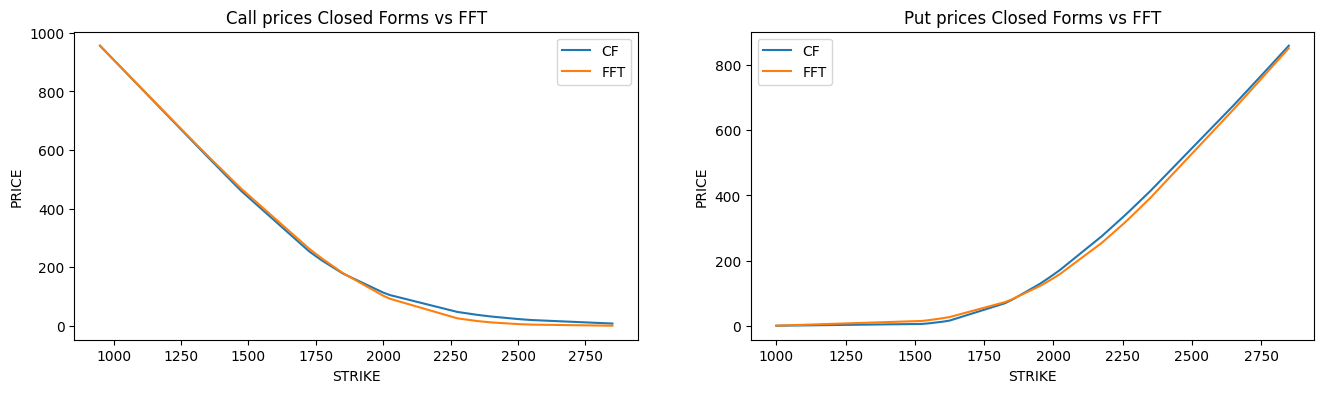

In [8]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label='CF')
ax1.plot(call_strikes, c_vg_fft, label='FFT')
ax1.set_title('Call prices Closed Forms vs FFT'); ax1.set_xlabel('STRIKE'); ax1.set_ylabel('PRICE')
# ax1.set_xlim([1400,2000]);ax1.set_ylim([0,800])

ax2.plot(put_strikes, put_th_prices['VarianceGamma'], label='CF')
ax2.plot(put_strikes, p_vg_fft, label='FFT')
ax2.set_title('Put prices Closed Forms vs FFT'); ax2.set_xlabel('STRIKE'); ax2.set_ylabel('PRICE')
ax1.legend(); ax2.legend()

## Implied volatility
The function belows implements $3$ methods to compute implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [9]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        X0 = [0.1, 0.5, 1, 3]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.5
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

The following code snippet computes the implied volatility of **call** and **put** options market prices.

In [10]:
IV_market_c = []
for i in range(len(call_prices)):
    IV_market_c.append(implied_volatility(call_prices[i], S=S0, strike=call_strikes[i], t = T, rate=r, q = q, type_o='call', method='fsolve'))

print(f'Implied volatilities of market prices (calls):\nS0 = {S0}')
for a,b in zip(call_strikes.tail(6), IV_market_c[-6:]):
    print(f'K = {a}, IV = {round(b, 4)}')

IV_market_p = []
for i in range(len(call_prices)):
    IV_market_p.append(implied_volatility(put_prices[i], S=S0, strike=put_strikes[i], t = T, rate=r, q = q, type_o='put', method='fsolve'))

print(f'Implied volatilities of market prices (puts):\nS0 = {S0}')
for a,b in zip(put_strikes.head(6), IV_market_p[:6]):
    print(f'K = {a}, IV = {round(b, 4)}')

Implied volatilities of market prices (calls):
S0 = 1859.48
K = 2275.0, IV = 0.1076
K = 2350.0, IV = 0.1052
K = 2400.0, IV = 0.1051
K = 2500.0, IV = 0.1078
K = 2550.0, IV = 0.113
K = 2850.0, IV = 0.1473
Implied volatilities of market prices (puts):
S0 = 1859.48
K = 1000.0, IV = 0.4112
K = 1525.0, IV = 0.3247
K = 1550.0, IV = 0.321
K = 1600.0, IV = 0.3147
K = 1625.0, IV = 0.3122
K = 1825.0, IV = 0.2935


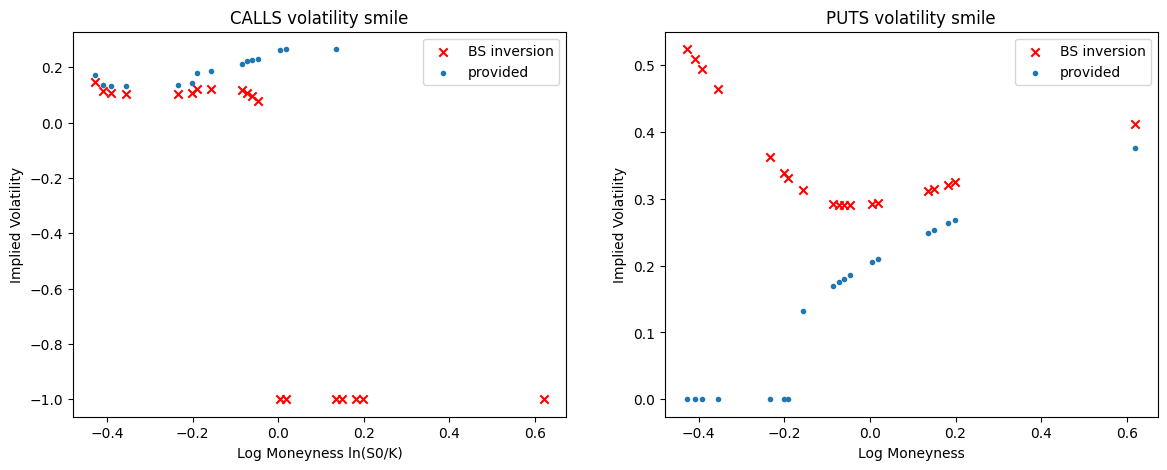

In [11]:
# Plot market implied volatilities w.r.t. log moneyness
x = np.log(S0/put_strikes)
# IV_filtered = [iv for iv in IV_market_p if iv != -1]
# x_filtered = [log_m for iv, log_m in zip(IV_market_p, x) if iv != -1]
IV_filtered = [iv for iv in IV_market_c if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market_c, x) if iv != -1]

fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

#CALLS
ax1.scatter(x, IV_market_c, marker='x', label='BS inversion', color='red')
ax1.scatter(x, calls['C_IV'], marker='.', label='provided')

#PUTS
ax2.scatter(x, IV_market_p, marker='x', label='BS inversion', color = 'red')
ax2.scatter(x, puts['P_IV'], marker= '.', label='provided')

ax1.set_xlabel('Log Moneyness ln(S0/K)'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('CALLS volatility smile')
ax2.set_xlabel('Log Moneyness'); ax2.set_ylabel('Implied Volatility')
ax2.set_title('PUTS volatility smile')
ax1.legend(); ax2.legend(); plt.show()


Therefore, we can compute the implied volatilities taking into account the theoretical **call prices**..

In [12]:
strikes = call_th_prices['Strike'].tolist(); IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(call_th_prices)):
    IV_BS.append(implied_volatility(call_th_prices['BlackScholes'].iloc[i], S=S0, strike=strikes[i], t=T, rate=r,q=q, type_o='call', method='newton') )
    IV_M.append(implied_volatility(call_th_prices['Merton'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_K.append(implied_volatility(call_th_prices['Kou'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_VG.append(implied_volatility(call_th_prices['VarianceGamma'].values[i], S=S0, strike=strikes[i], t = T, rate=r, q=q, type_o='call', method='newton'))

imp_vol_call = pd.DataFrame(columns=['Strike', 'BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_call['Strike'] = strikes
imp_vol_call['BlackScholes'] = IV_BS
imp_vol_call['Merton'] = IV_M
imp_vol_call['Kou'] = IV_K
imp_vol_call['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for call options:\n{imp_vol_call.head(7)}')

Implied volatilities found by each model for call options:
   Strike  BlackScholes    Merton       Kou  VarianceGamma
0   950.0           0.2  0.280271  0.306035       0.155837
1   975.0           0.2  0.277462  0.301361       0.154906
2  1000.0           0.2  0.274692  0.296719       0.154028
3  1300.0           0.2  0.243429  0.242252       0.148455
4  1350.0           0.2  0.238191  0.233221       0.148647
5  1450.0           0.2  0.227285  0.215399       0.150283
6  1475.0           0.2  0.224461  0.211076       0.150967


... and **put prices**.

In [13]:
strikes = put_th_prices['Strike'].tolist(); IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(put_prices)):
    IV_BS.append(implied_volatility(put_th_prices['BlackScholes'].values[i], S=S0, strike=strikes[i], t=T, rate=r, q=q, type_o='put', method='newton' ) )
    IV_M.append(implied_volatility(put_th_prices['Merton'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_K.append(implied_volatility(put_th_prices['Kou'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_VG.append(implied_volatility(put_th_prices['VarianceGamma'].values[i], S=S0, strike=strikes[i], t = T, rate=r, q=q, type_o='put', method='newton'))

imp_vol_put = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_put['Strike'] = strikes
imp_vol_put['BlackScholes'] = IV_BS
imp_vol_put['Merton'] = IV_M
imp_vol_put['Kou'] = IV_K
imp_vol_put['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for put options:\n {imp_vol_put.head(7)}')

Implied volatilities found by each model for put options:
    Strike  BlackScholes    Merton       Kou  VarianceGamma
0  1000.0           0.2  0.274692  0.296719       0.154028
1  1525.0           0.2  0.218715  0.202736       0.152666
2  1550.0           0.2  0.215809  0.198768       0.153671
3  1600.0           0.2  0.209989  0.191354       0.155956
4  1625.0           0.2  0.207103  0.187949       0.157215
5  1825.0           0.2  0.186602  0.169169       0.168674
6  1850.0           0.2  0.184553  0.167844       0.170154


In [14]:
print('Total absolute error IV from CALLS vs IV from PUTS: ')
print(f'> BS: ', np.linalg.norm(imp_vol_put['BlackScholes'] - imp_vol_call['BlackScholes'], 1))
print(f'> MERTON: ', np.linalg.norm(imp_vol_put['Merton'] - imp_vol_call['Merton'], 1))
print(f'> KOU: ', np.linalg.norm(imp_vol_put['Kou'] - imp_vol_call['Kou'], 1))
print(f'> VG: ', np.linalg.norm(imp_vol_put['VarianceGamma'] - imp_vol_call['VarianceGamma'], 1))

Total absolute error IV from CALLS vs IV from PUTS: 
> BS:  2.1983239045786362e-07
> MERTON:  0.3672464513014789
> KOU:  0.4748343323085923
> VG:  0.15759352082176667


##### Plot

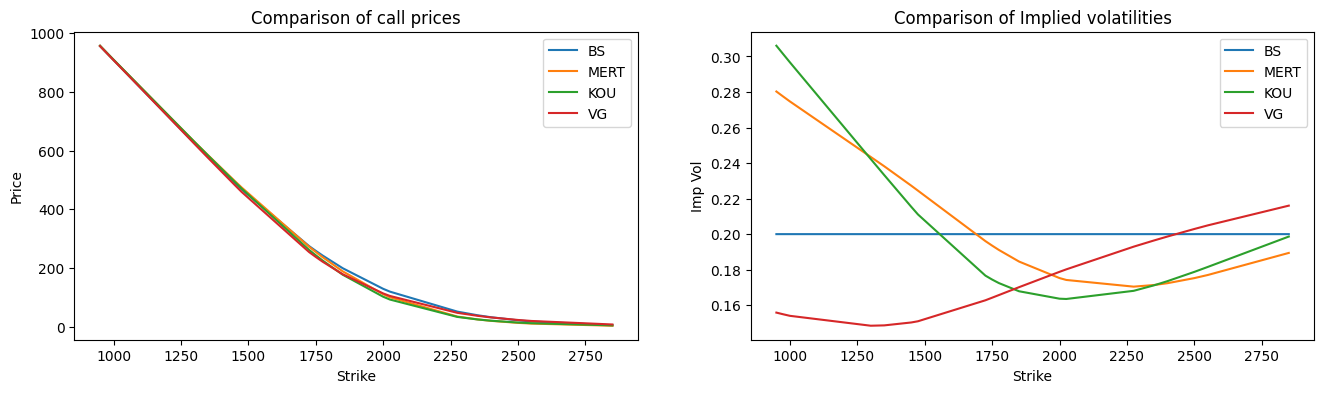

In [15]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(call_strikes, call_th_prices['BlackScholes'], label="BS"); ax1.plot(call_strikes, call_th_prices['Merton'], label="MERT")
ax1.plot(call_strikes, call_th_prices['Kou'], label="KOU"); ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label="VG")
ax1.set_title("Comparison of call prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(call_strikes, imp_vol_call['BlackScholes'], label="BS"); ax2.plot(call_strikes, imp_vol_call['Merton'], label="MERT")
ax2.plot(call_strikes, imp_vol_call['Kou'], label="KOU"); ax2.plot(call_strikes, imp_vol_call['VarianceGamma'], label="VG")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

##  Calibration
Let's step now into the calibration of model parameters.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $P_i$ are the market prices and  $f$ is the pricing function. In our case $f$ is given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. To perfrom this optimization problem, many numerical methods can be used. In oarticular, we test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works both with and without bounds. When bounds are set it uses the [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region) and the [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) when they are not.
2. **minimize(method='SLSQP')**, a constrained minimization problem which uses [Sequential Quadratic Programming](https://en.wikipedia.org/wiki/Sequential_quadratic_programming).
First we initialize a starting point in the array $x_0 = [σ, λ, m, v]$, then we set


### Black and Scholes model
The only unknown parameter to calibrate in Black and Scholes model is the **implied volatility**, $\sigma$. Thus, we minimize the difference between the computed theoretical prices and the market prices of both call and put options.

In [27]:
x0 = 0.4
bounds =( [0], [np.inf])

# CALL OPTIONS
def f_BlackScholes_call(x, sigm):
    BS = BS_pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise='call')
    return BS.closed_formula_call(x)

res1_calls = scpo.curve_fit(f_BlackScholes_call, call_strikes, call_prices, p0 = x0, bounds=bounds)
sigt_c = round(res1_calls[0][0],4)

# PUT OPTIONS
def f_BlackScholes_put(x, sigm):
    BS = BS_pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise='put')
    return BS.closed_formula_put(x)

res1_puts = scpo.curve_fit(f_BlackScholes_put, put_strikes, put_prices, p0 = x0, bounds=bounds)
sigt_p = round(res1_puts[0][0],4)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigt_c} \t {round(sigt_c*100,2)}%')
print(f'> Calibrated Volatility from Puts [σ] = {sigt_p} \t {round(sigt_p*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.1126 	 11.26%
> Calibrated Volatility from Puts [σ] = 0.3414 	 34.14%


In [26]:
x0 = 0.2    # initial guess: [σ, λ, m, v]
bounds = [(0, np.inf)]

# Define the objective function for calls
def obj_function(x, strikes, prices):
    sigm = x
    BS = BS_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, exercise='call')
    return np.sum((BS.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2_calls = scpo.minimize(obj_function, x0, args=additional_args, bounds=bounds, tol=1e-20)
# print(res2_1.message)
sigt2_c =  res2_calls.x[0]

# Define the objective function for puts
def obj_function(x, strikes, prices):
    sigm = x
    BS = BS_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, exercise='put')
    return np.sum((BS.closed_formula_put(K) - prices) ** 2)

additional_args = (put_strikes, put_prices)
res2_puts = scpo.minimize(obj_function, x0, args=additional_args, bounds=bounds, tol=1e-20)
# print(res2_1.message)
sigt2_p =  res2_puts.x[0]


# Print the results
print('> METHOD 2: MINIMIZE')
print(f'Calibrated Volatility from Calls [σ] = {round(sigt2_c, 5)}, \t  {round(sigt2_c*100,2)}%')
print(f'Calibrated Volatility from Puts [σ] = {round(sigt2_p, 5)}, \t  {round(sigt2_p*100,2)}%')

> METHOD 2: MINIMIZE
Calibrated Volatility from Calls [σ] = 0.70085, 	  70.09%
Calibrated Volatility from Puts [σ] = 0.0, 	  0.0%


C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\BSpricer.py:92: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(self.S0 / self.K) + (self.r + self.sigma ** 2 / 2) * self.ttm) / (self.sigma * np.sqrt(self.ttm))
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\BSpricer.py:93: RuntimeWarning: divide by zero encountered in divide
  d2 = (np.log(self.S0 / self.K) + (self.r - self.sigma ** 2 / 2) * self.ttm) / (self.sigma * np.sqrt(self.ttm))


### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [ ]:
x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 1e-2, -10, 0.1], [np.inf, np.inf, 10, 5] )

def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)


##### Method 1. Bounds

In [ ]:
res1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],4)
lambdt = round(res1[0][1],2)
mt = round(res1[0][2],2)
vt = round(res1[0][3],5)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigt} \t {round(sigt*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Jump Mean = ', mt)
print('> Calibrated Jump St. dev.  = ', vt)

##### Method 1. No bounds

In [ ]:
res1_2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0)

sigt2 = round(res1_2[0][0],4)
lambdt2 = round(res1_2[0][1],2)
mt2 = round(res1_2[0][2],2)
vt2 = round(res1_2[0][3],5)

print('METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)')
print(f'> Calibrated Volatlity [σ] = {sigt2} \t {round(sigt2*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', lambdt2)
print('> Calibrated Jump Mean = ', mt2)
print('> Calibrated Jump St. dev.  = ', vt2)

##### Method 2. Bounds

In [ ]:
x0 = [0.3, 0.8, -0.3, 0.4]      # initial guess: [σ, λ, m, v]
bounds = [(1e-6, 10), (0, 20), (-10, 10),  (0, 15)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, mean, std = x
    Mert = Merton_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, lambd=lamb, meanJ=mean, stdJ=std, exercise=exercise)
    return np.sum((Mert.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

print('> METHOD 2: MINIMIZE (SLSQP)')
res2_1 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)
print(res2_1.message)
sigt3, lambdt3, mt3, vt3 = res2_1.x

# Print the results
print(f'Calibrated Volatility [σ] = {round(sigt3, 5)}, \t  {round(sigt3*100,2)}%')
print('Calibrated Jump Intensity [λ] =', round(lambdt3, 2))
print('Calibrated Jump Mean [m] =', round(mt3, 2))
print('Calibrated Jump St. dev. [v] =', round(vt3, 2))


print('\n> METHOD 2: MINIMIZE (trust-constr)')
res2_2 = scpo.minimize(obj_function, x0, args=additional_args,  method='trust-constr', bounds=bounds, tol=1e-20)
print(res2_1.message)
sigt4, lambdt4, mt4, vt4 = res2_2.x

# Print the results
print(f'Calibrated Volatility [σ] = {round(sigt4, 5)}, \t  {round(sigt4*100,2)}%')
print('Calibrated Jump Intensity [λ] =', round(lambdt4, 2))
print('Calibrated Jump Mean [m] =', round(mt4, 2))
print('Calibrated Jump St. dev. [v] =', round(vt4, 2))

In [ ]:
mert_params = [sigt, lambdt, mt, vt]
print(mert_params)

### Kou Jump Diffusion

In [ ]:
x0 = [0.1, 0.5, 0.4, 5, 5] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [0, 0, 0, 0, 0], [4, 10, 0.9,  10, 10] )

def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_call(x)

##### Method 1. TRF (Bounds)

In [ ]:
res1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
pt = round(res1[0][2],2)
eta1_t = round(res1[0][3],1)
eta2_t = round(res1[0][4],1)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigt} \t {round(sigt*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', lambdt)
print(f'> Calibrated Upward Jump probability [p] = {pt}, [q] = {round(1-pt,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', eta1_t)
print('> Calibrated Rate of Exp. 2  [η_2] = ', eta2_t)

##### Method 2. Bounds

In [ ]:
x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_2]
bounds = [(0, 4), (0, 10), (0, 1),  (1e-6, 10), (1e-6,10)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, p, eta1, eta2 = x
    KouJD = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return np.sum((KouJD.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)
print('METHOD 2: MINIMIZE (SLSQP)'); print(f'message: {res2.message}\nsuccess:{res2.success}')

sigt2, lambdt2, pt2, eta1_t2, eta2_t2 = res2.x

print(f'> Calibrated Volatlity [σ] = {round(sigt2,4)} \t {round(sigt2*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(lambdt2,2))
print(f'> Calibrated Upward Jump probability [p] = {round(pt2,2)}, [q] = {round(1-pt2,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(eta1_t2,2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(eta2_t2,2))

res3 = scpo.minimize(obj_function, x0, args=additional_args,  method='trust-constr', bounds=bounds, tol=1e-20)
print('METHOD 2: MINIMIZE (trust-constr)'); print(f'message: {res3.message}\nsuccess:{res3.success}')

sigt3, lambdt3, pt3, eta1_t3, eta2_t3 = res3.x

print(f'> Calibrated Volatlity [σ] = {round(sigt3,4)} \t {round(sigt3*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(lambdt3,2))
print(f'> Calibrated Upward Jump probability [p] = {round(pt3,2)}, [q] = {round(1-pt3,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(eta1_t3,2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(eta2_t3,2))

The following code snippet samples a subset of observations in order to speed up the estimation of parameters in Kou's model.

In [ ]:
# # Sample of rows of the call dataframe
# call_resized = calls.sample(n=6).sort_index()
# c_strikes_resized = call_resized['STRIKE']
# c_prices_resized = call_resized['C_Midpoint']
#
# x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_2]
#
# bounds1 = ( [0, 0, 0, 1e-9, 1e-9], [4, 10, 1,  10, 10] )
# res1 = scpo.curve_fit(f_Kou, c_strikes_resized, c_prices_resized, p0=x0, bounds=bounds1)
# print(res1[0])
#
# bounds2 = [(0, 4), (0, 10), (0, 1),  (1e-9, 20), (1e-9,20)]
# additional_args = (c_strikes_resized, c_prices_resized)
# res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)
# print(res2)

In [ ]:
kou_params = [sigt, lambdt, pt, eta1_t, eta2_t]
print(kou_params)

### Variance Gamma


In [ ]:
x0 = [0.2, -0.05, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-2, -10, 0], [5, 10, 20] )

##### Method 1. Bounds (TRF)

In [ ]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

res1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
thetat = round(res1[0][1],2)
nut = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)');
print(f'> Calibrated Volatlity [σ] = {sigt}, \t {round(sigt*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', thetat)
print('> Calibrated variance rate gamma process [v]= ', nut)

##### Method 2. Bounds

In [ ]:
bounds2 = [(1e-9, 5), (-4, np.inf), (0, np.inf)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, theta, nu = x
    VGx = VG_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, theta=theta, nu=nu, exercise=exercise)
    return np.sum((VGx.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

# METHOD SEQUENTIAL LEAST SQUARES
res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)
print('METHOD 2: MINIMIZE (SLSQP)'); print(f'message: {res2.message}\nsuccess: {res2.success}')
sigt2, thetat2, nut2 = res2.x

# Print the results
print(f'> Calibrated Volatlity [σ] = {round(sigt2,4)} \t {round(sigt2*100, 2)}%')
print('> Calibrated mean rate gamma process [θ] = ', round(thetat2, 2))
print('> Calibrated variance rate gamma process [v]= ', round(nut2,2))

# METHOD TRUST REGION CONSTRAINED
res3 = scpo.minimize(obj_function, x0, args=additional_args,  method='trust-constr', bounds=bounds2, tol=1e-20)
print('METHOD 2: MINIMIZE (trust-constr)'); print(f'message: {res3.message}\nsuccess: {res3.success}')
sigt3, thetat3, nut3 = res3.x

# Print the results
print(f'> Calibrated Volatlity [σ] = {round(sigt3,4)} \t {round(sigt3*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', round(thetat3,2))
print('> Calibrated variance rate gamma process [v]= ', round(nut3,2))

##### Method 1 using FFT prices

In [ ]:
def f_VG_fft(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    return VGamma.FFT_call(strikes)

res4 = scpo.curve_fit(f_VG_fft, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt4 = round(res1[0][0],5)
thetat4 = round(res1[0][1],2)
nut4 = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(sigt4,4)} \t {round(sigt4*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', thetat4)
print('> Calibrated variance rate gamma process [v]= ', nut4)

In [ ]:
vg_params = [sigt, thetat, nut]
print(vg_params)

## Weighted calibration
Considering the original formula of the calibration, we can add a weight parameter $w_i$ that allows to give more importance to the market prices with smaller spread. Thus, the optimization objective function  becomes:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i }$$


In [29]:
spreads = calls['C_Spread']
#for a, b, c in zip(call_strikes, call_prices, spreads):
#    print(a, b,c )

### Black and Scholes

In [30]:
x0 = 0.4
bounds =( [0], [np.inf])

# CALL OPTIONS
def f_BlackScholes_call(x, sigm):
    BS = BS_pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise='call')
    return BS.closed_formula_call(x)

res1_calls = scpo.curve_fit(f_BlackScholes_call, call_strikes, call_prices, p0 = x0, bounds=bounds, sigma= spreads)
sigw_c = round(res1_calls[0][0],4)

# PUT OPTIONS
def f_BlackScholes_put(x, sigm):
    BS = BS_pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise='put')
    return BS.closed_formula_put(x)

res1_puts = scpo.curve_fit(f_BlackScholes_put, put_strikes, put_prices, p0 = x0, bounds=bounds, sigma = spreads)
sigw_p = round(res1_puts[0][0],4)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigw_c} \t {round(sigw_c*100,2)}%')
print(f'> Calibrated Volatility from Puts [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.1139 	 11.39%
> Calibrated Volatility from Puts [σ] = 0.4164 	 41.64%


### Merton Jump diffusion

In [31]:
# using call prices
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)

x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 1e-2, -10, 0.1], [np.inf, np.inf, 10, 5] )
mert_params2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=spreads)

In [ ]:
sigw = round(mert_params2[0][0],4)
lambdw = round(mert_params2[0][1],2)
mw = round(mert_params2[0][2],2)
vw = round(mert_params2[0][3],5)

print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigw} \t {sigw*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdw)
print('> Calibrated Jump Mean = ', mw)
print('> Calibrated Jump St. dev.  = ', vw)

mert_params2 = [sigw, lambdw, mw, vw]

In [34]:
print(mert_params2)

[0.1132, 0.01, 0.07, 0.10001]


### Kou Jump Diffusion

In [35]:
def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_call(x)

x0 = [0.1, 0.5, 0.4, 5, 5] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [0, 0, 0, 0, 0], [4, 10, 0.9,  10, 10] )
kou_params2 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=spreads)

In [36]:
sigw = round(kou_params2[0][0],5)
lambdw = round(kou_params2[0][1],2)
pw = round(kou_params2[0][2],2)
eta1_w = round(kou_params2[0][3],1)
eta2_w = round(kou_params2[0][4],1)

print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigw} \t {sigw*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdw)
print(f'> Calibrated Upward Jump probability [p] = {pw}, [q] = {round(1-pw,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', eta1_w)
print('> Calibrated Rate of Exp. 2  [η_2] = ', eta2_w)

kou_params2 = [sigw, lambdw, pw, eta1_w, eta2_w]
print(kou_params2)

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.11389 	 11.389000000000001%
> Calibrated Jump intensity [λ] =  0.0
> Calibrated Upward Jump probability [p] = 0.9, [q] = 0.1
> Calibrated Rate of Exp. 1  [η_1] =  9.4
> Calibrated Rate of Exp. 2  [η_2] =  1.7
[0.11389, 0.0, 0.9, 9.4, 1.7]


### Variance Gamma

In [37]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

x0 = [0.2, -0.05, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-2, -10, 0], [5, 10, 20] )
vg_params2 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=spreads)

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:50: RuntimeWarning: overflow encountered in exp
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:50: RuntimeWarning: invalid value encountered in scalar divide
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:50: RuntimeWarning: invalid value encountered in scalar multiply
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved

In [38]:
sigw = round(vg_params2[0][0],5)
thetaw = round(vg_params2[0][1],2)
nuw = round(vg_params2[0][2],2)

print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigw}, \t {round(sigw*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', thetaw)
print('> Calibrated variance rate gamma process [v]= ', nuw)

vg_params2 = [sigw, thetaw, nuw]

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.09033, 	 9.03%
> Calibrated mean rate gamma process [θ] =  -0.56
> Calibrated variance rate gamma process [v]=  0.01


In [39]:
print(vg_params2)

[0.09033, -0.56, 0.01]
